In [1]:
import pandas as pd
import Procedatos as P
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from random import choice
from scipy.stats import kurtosis, skew
import warnings
warnings.filterwarnings('ignore')
from Graficos import *

In [2]:
df1 = P.leer_datos([12],[1],[100],[100], verb=False,muchos=False,cola=False)
df1['Prediccion_lag'] = df1.groupby(['Identificador','Agente'])['Prediccion'].transform('shift',1)
df1['Attendance'] = df1.groupby(['Identificador','Ronda'])['Estado'].transform('sum')
# df1.head()

df12 = P.leer_datos([12],[12],[100],[100], verb=False,muchos=False,cola=False)
df12['Prediccion_lag'] = df12.groupby(['Identificador','Agente'])['Prediccion'].transform('shift',1)
df12['Attendance'] = df12.groupby(['Identificador','Ronda'])['Estado'].transform('sum')
# df12.head()

In [3]:
trial = 10

In [4]:
def graficar(data, x=0, r_ini=84, n_rounds=5, k=0):
    ids = list(data['Identificador'].unique())
    # ident = choice(ids)
    ident = ids[x]
    inicial = True
    fig, ax = plt.subplots(n_rounds,3, figsize=(8,2*n_rounds), tight_layout=True, dpi=300)
    fig.suptitle(f'Rounds {r_ini} through {r_ini + n_rounds} (k={k})', fontsize=14)
    for r in range(n_rounds):
        if inicial:
            ax[r,0].set_title(f'Distribution of\nPredictions from\nactive predictors')
            ax[r,1].set_title(f'Decisions')
            ax[r,2].set_title('Distribution of\ndistances between\nPrediction and Attendance')
            inicial = False
        else:
            ax[r,0].set_title('')
            ax[r,1].set_title('')
            ax[r,2].set_title('')
        df = pd.DataFrame(data[data['Ronda'] == r_ini+r])
        df['Asistencia'] = df.groupby('Identificador')['Estado'].transform('sum')
        df['Estado1'] = df['Estado'].apply(lambda x: 'Go' if x == 1 else 'No go')
        df = pd.DataFrame(df[df['Identificador'] == ident])
        df['|P-A|'] = np.abs(df['Prediccion_lag'] - df['Asistencia'])
        sns.histplot(x='Prediccion_lag', data=df, kde=True, ax=ax[r,0], bins=50)
        sns.countplot(x='Estado1', order=['Go', 'No go'], data=df, ax=ax[r,1])
        sns.histplot(x='|P-A|', data=df, kde=True, ax=ax[r,2])
        ax[r,0].set_xlim([0,100])
        ax[r,0].set_xlabel('')
        ax[r,0].axvline(60, ls='--', color='red')
        ax[r,1].set_ylim([0,100])
        ax[r,1].set_xlabel('')
        ax[r,1].axhline(60, ls='--', color='red')
        ax[r,1].set_ylabel('')
#        ax[r,1].tick_params(labelleft=False)
        ax[r,2].set_xlim([0,100])
        ax[r,2].set_xlabel('')
        ax[r,2].set_ylabel('')
#        ax[r,2].tick_params(labelleft=False)
    fig.savefig(f'rondas-{k}.png')

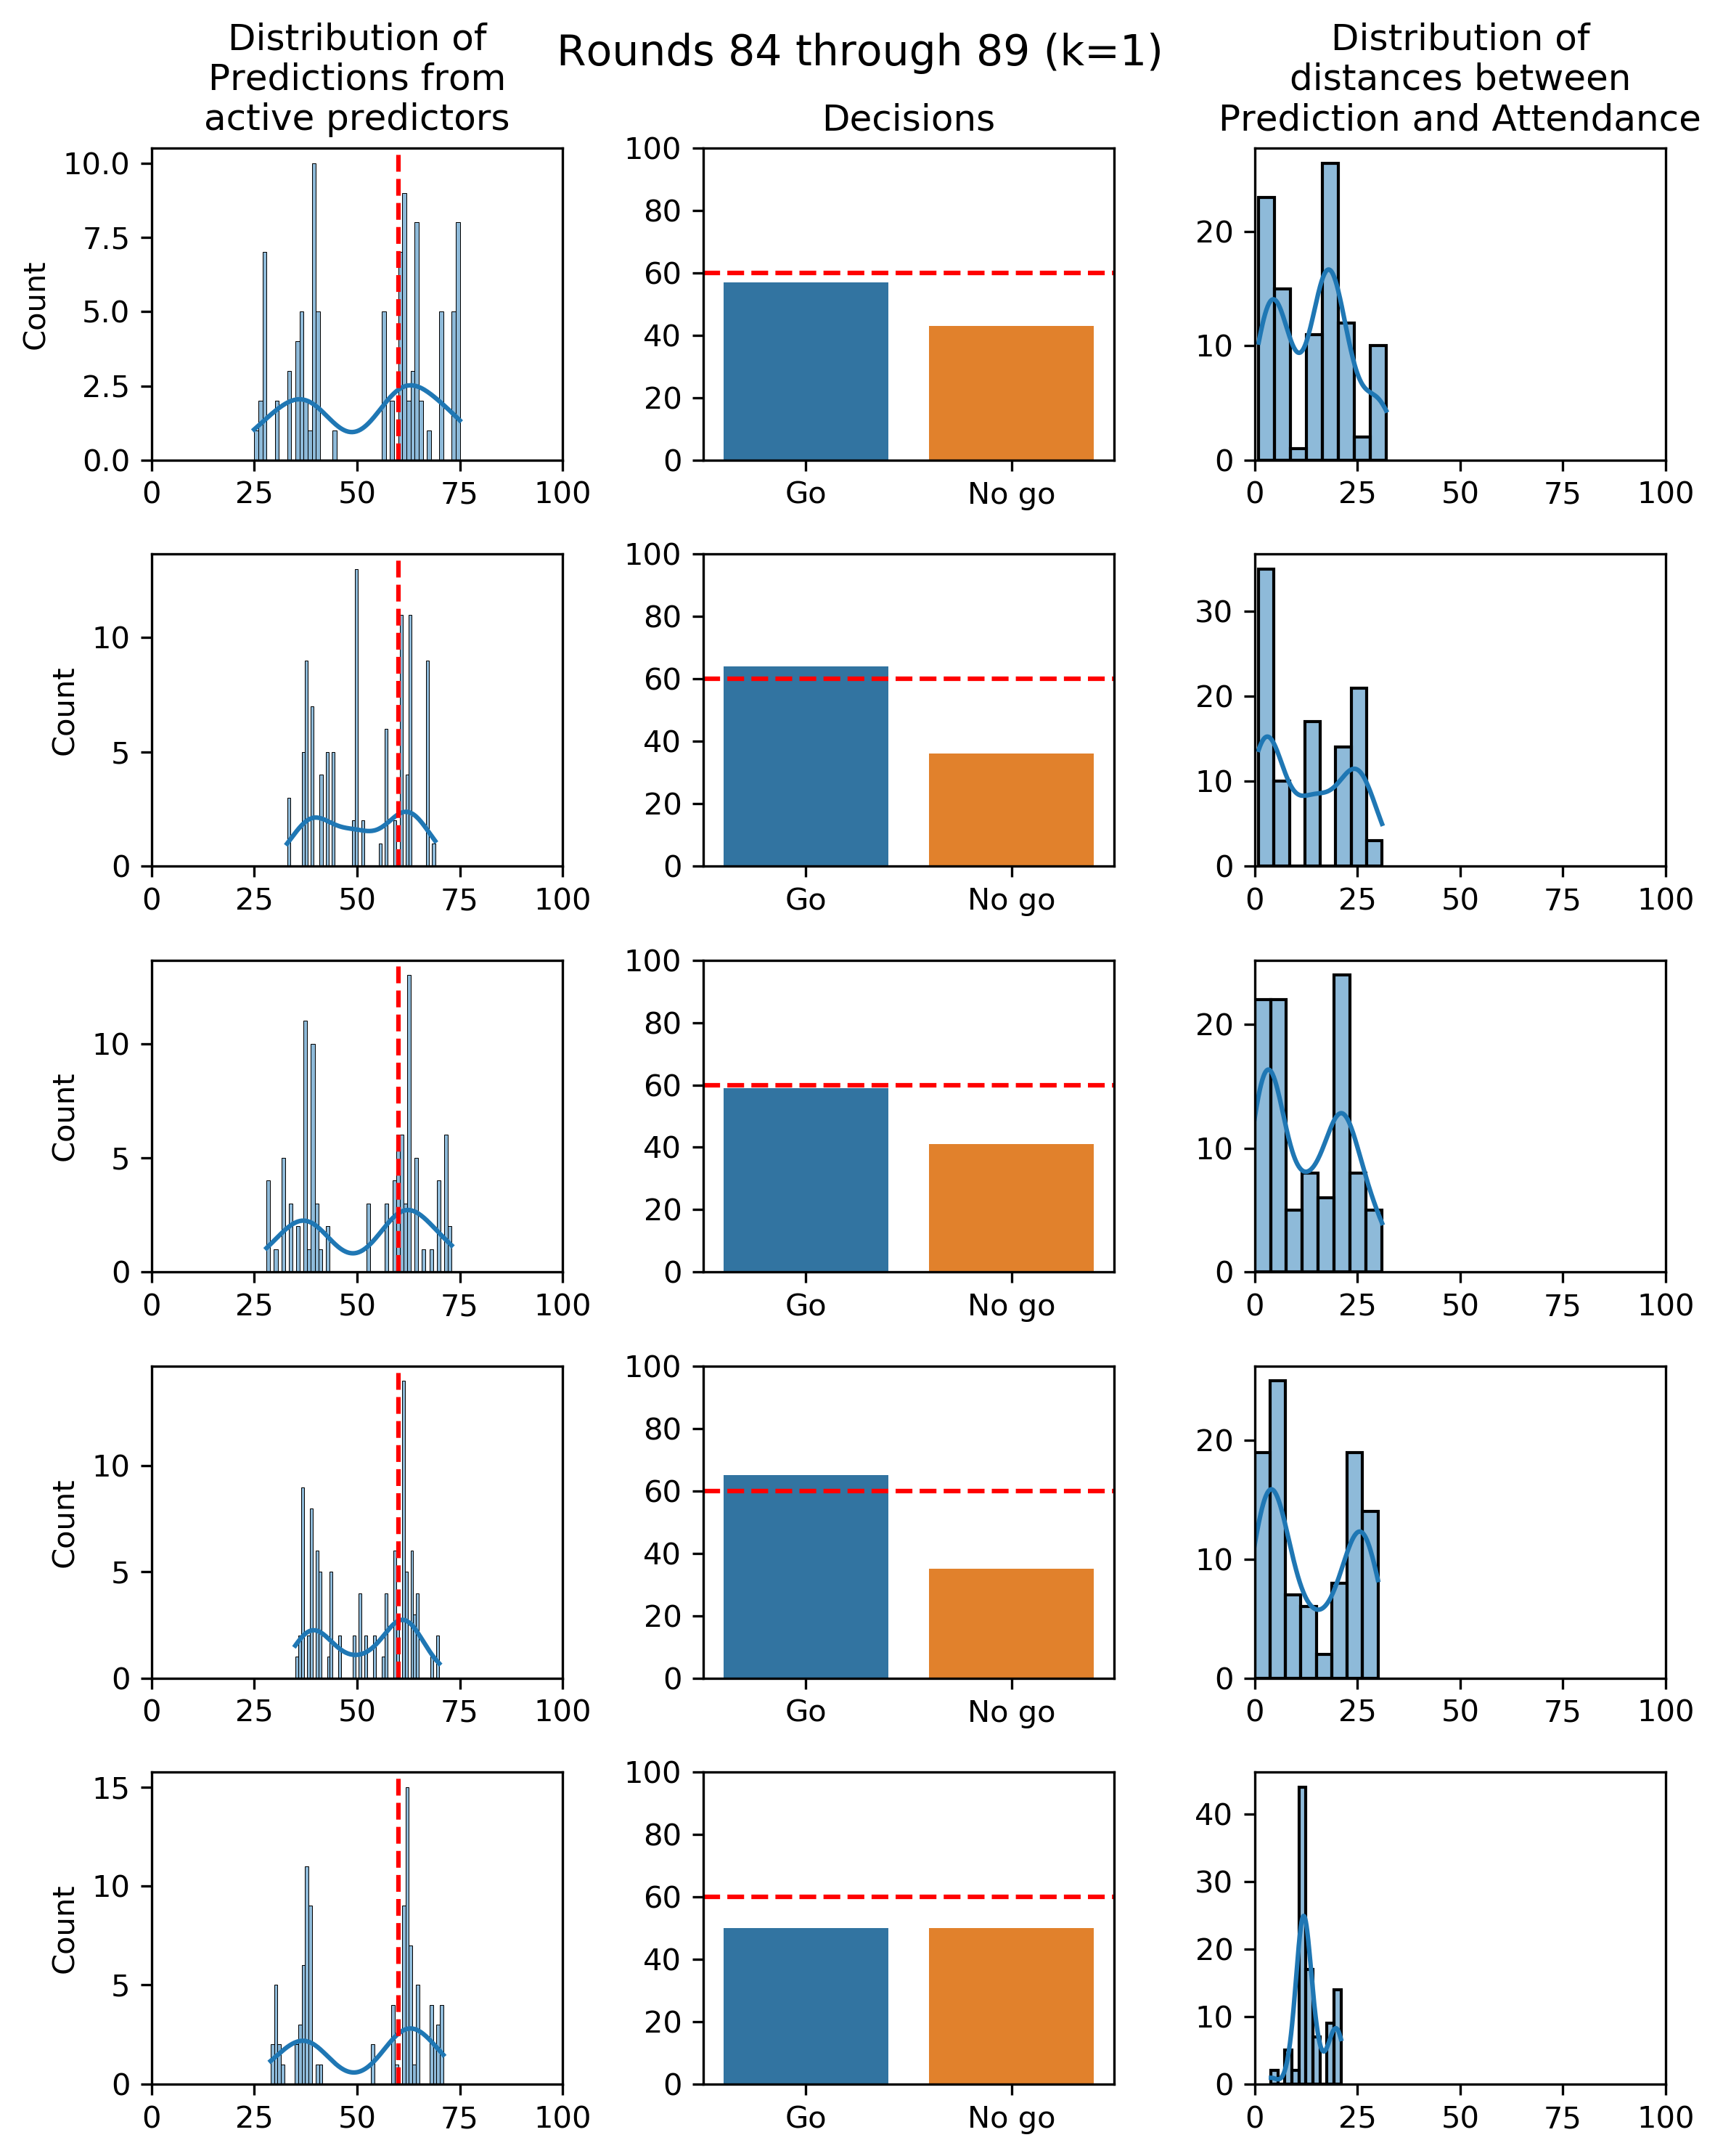

In [5]:
graficar(df1, trial, 84, 5, 1)

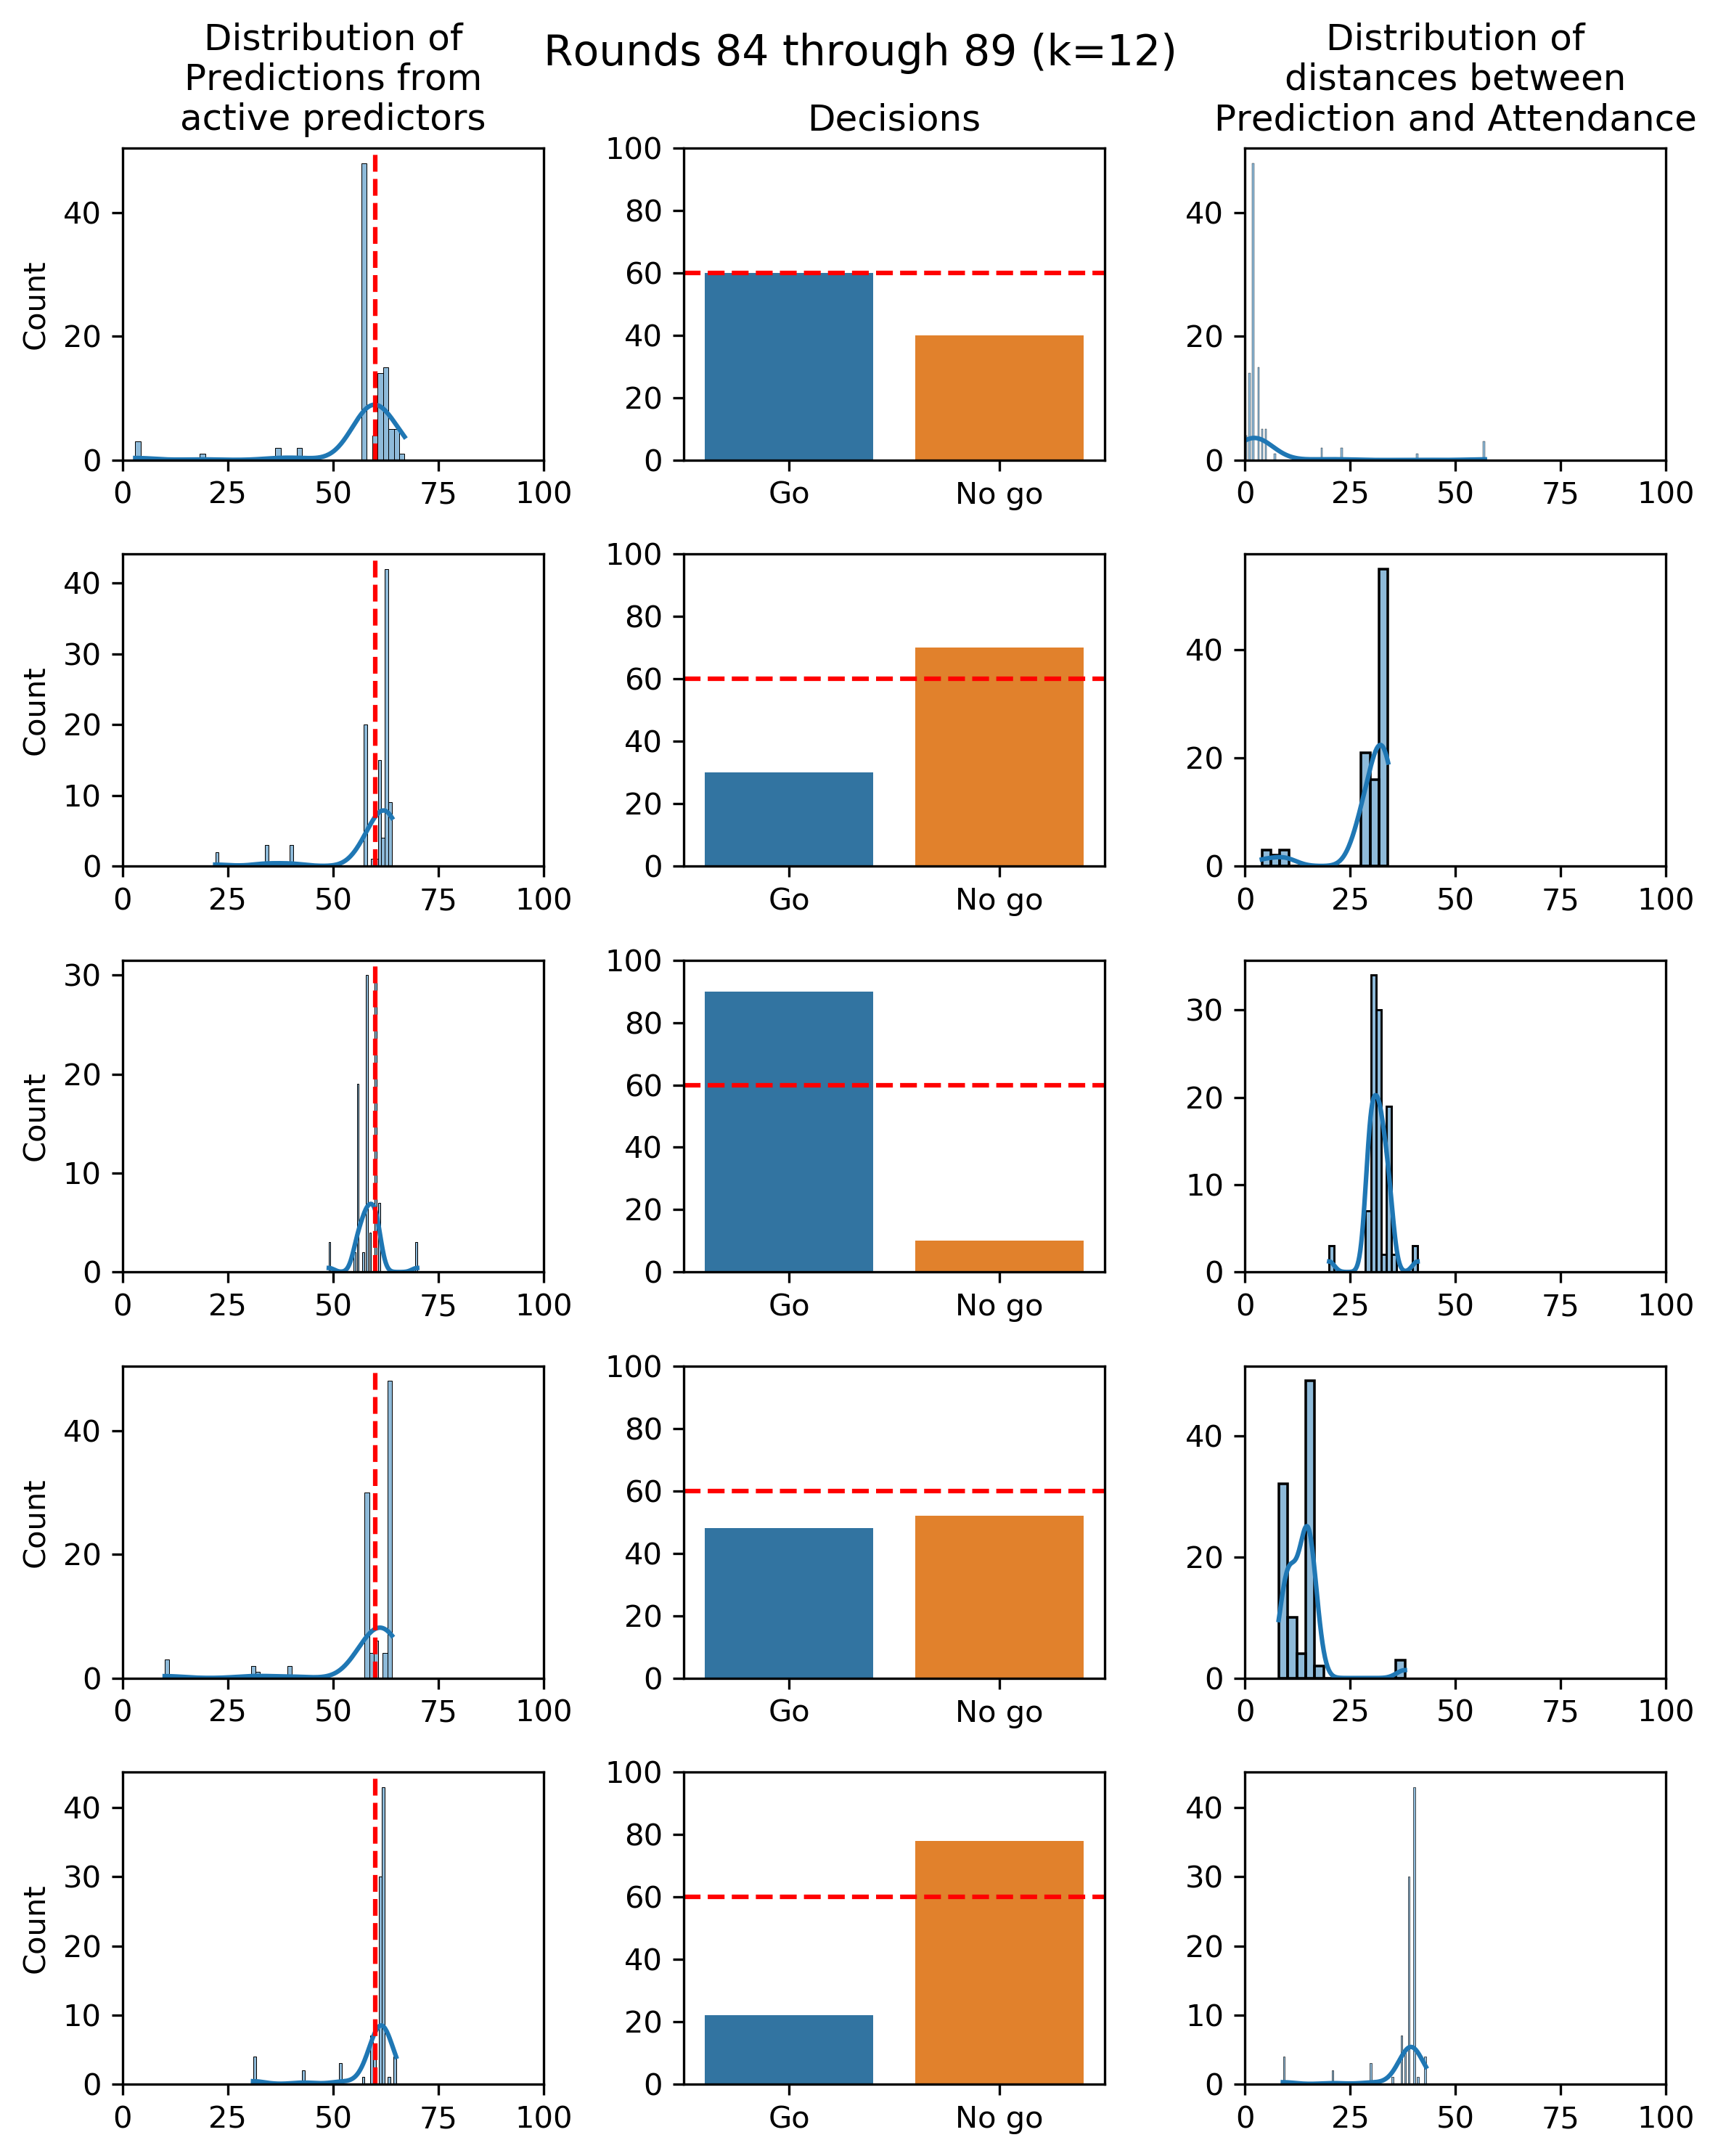

In [6]:
graficar(df12, trial, 84, 5, 12)

In [7]:
def dif_mods(data1, data2, x=0):
    # Filtering dataframes for trial
    ids = list(data1['Identificador'].unique())
    ident = ids[x]
    dfA = pd.DataFrame(data1[data1['Identificador'] == ident])
    ids = list(data2['Identificador'].unique())
    ident = ids[10]
    dfB = pd.DataFrame(data2[data2['Identificador'] == ident])
    # Obtaining variables to draw
    df1A = dfA.groupby('Ronda')['Prediccion_lag'].value_counts().reset_index(name='Conteo')
    df2A = df1A.groupby('Ronda').apply(lambda x: diferencia(list(x['Prediccion_lag']), list(x['Conteo']))).reset_index()
    df2A.columns = ['Ronda','Dif_modes']
    df1B = dfB.groupby('Ronda')['Prediccion_lag'].value_counts().reset_index(name='Conteo')
    df2B = df1B.groupby('Ronda').apply(lambda x: diferencia(list(x['Prediccion_lag']), list(x['Conteo']))).reset_index()
    df2B.columns = ['Ronda','Dif_modes']
    # Plotting
    fig, ax = plt.subplots(1,2, figsize=(4,2), tight_layout=True, dpi=300)
    sns.lineplot(x='Ronda',y='Dif_modes',data=df2A,ax=ax[0])
    sns.lineplot(x='Ronda',y='Dif_modes',data=df2B,ax=ax[1])
    max1 = ax[0].get_ylim()[1]
    max2 = ax[1].get_ylim()[1]
    maximo = max(max1, max2)
    ax[0].set_ylim([0,maximo])
#    ax[0].set_ylabel('Absolute difference\nin prediction modes\nfrom active predictors')
    ax[0].set_title('$k=1$')
    ax[0].set_ylabel('$\Delta m$')
    ax[0].set_xlabel('Round')
    ax[0].grid()
    ax[1].set_title('$k=12$')
    ax[1].set_ylim([0,maximo])
    ax[1].set_ylabel('')
    ax[1].set_xlabel('Round')
    ax[1].tick_params(labelleft=False, left=False)
    ax[1].grid()
#    fig.suptitle('Difference between 1st and 2nd\nmost frequent predictions', fontsize=10)
    fig.savefig('dif-mods.png')

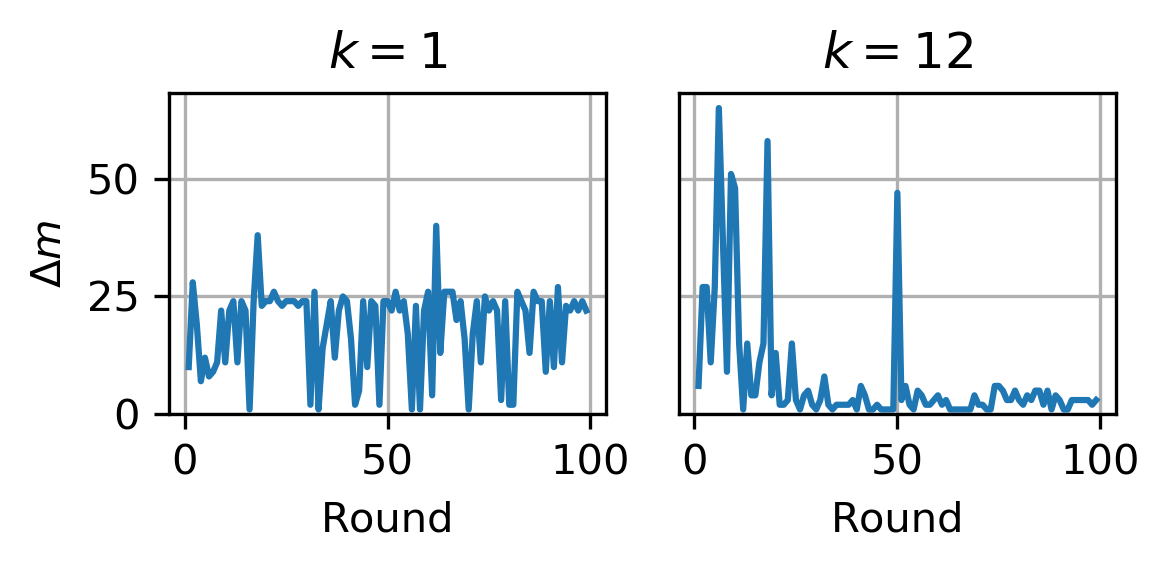

In [8]:
dif_mods(df1, df12, trial)

In [23]:
def dif_prods(data1, data2, x=0):
    # Filtering dataframes for trial
    ids = list(data1['Identificador'].unique())
    ident = ids[x]
    dfA = pd.DataFrame(data1[data1['Identificador'] == ident])
    ids = list(data2['Identificador'].unique())
    ident = ids[10]
    dfB = pd.DataFrame(data2[data2['Identificador'] == ident])
    # Obtaining variables to draw
    dfAp = dfA.groupby('Ronda')['Prediccion_lag'].apply(lambda x: np.mean(x)).reset_index(name='Av.Prediction')
    dfBp = dfB.groupby('Ronda')['Prediccion_lag'].apply(lambda x: np.mean(x)).reset_index(name='Av.Prediction')
    # Plotting
    fig, ax = plt.subplots(1,2, figsize=(4,2), tight_layout=True, dpi=300)
    sns.lineplot(x='Ronda', y='Av.Prediction', data=dfAp, ax=ax[0])
    sns.lineplot(x='Ronda', y='Av.Prediction', data=dfBp, ax=ax[1])
    max1 = ax[0].get_ylim()[1]
    max2 = ax[1].get_ylim()[1]
    maximo = max(max1, max2)
    ax[0].set_ylim([0,maximo])
#    ax[0].set_ylabel('Absolute difference\nin prediction modes\nfrom active predictors')
    ax[0].set_title('$k=1$')
    ax[0].set_ylabel('Average prediction')
    ax[0].set_xlabel('Round')
    ax[0].grid()
    ax[0].axhline(60, ls='--', color='red', linewidth=.5)
    ax[1].set_title('$k=12$')
    ax[1].set_ylim([0,maximo])
    ax[1].set_ylabel('')
    ax[1].set_xlabel('Round')
    ax[1].tick_params(labelleft=False, left=False)
    ax[1].grid()
    ax[1].axhline(60, ls='--', color='red', linewidth=.5)
#    fig.suptitle('Difference between 1st and 2nd\nmost frequent predictions', fontsize=10)
    fig.savefig('dif-prods.png')

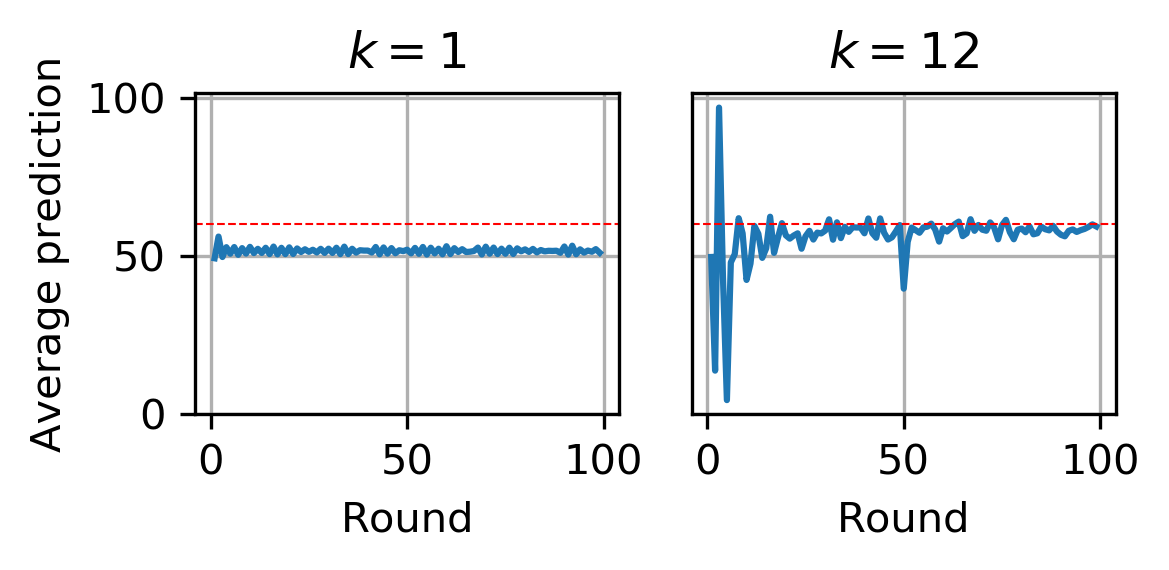

In [24]:
dif_prods(df1, df12, trial)

In [9]:
def comparar(data1, data2, x=0):
    # Filtering dataframes for trial
    ids = list(data1['Identificador'].unique())
    ident = ids[x]
    dfA = pd.DataFrame(data1[data1['Identificador'] == ident])
    ids = list(data2['Identificador'].unique())
    ident = ids[10]
    dfB = pd.DataFrame(data2[data2['Identificador'] == ident])
    # Obtaining variables to draw
    dfAk = dfA.groupby('Ronda')['Prediccion_lag'].apply(lambda x: np.var(x)).reset_index(name='Variance')
    dfBk = dfB.groupby('Ronda')['Prediccion_lag'].apply(lambda x: np.var(x)).reset_index(name='Variance')
    dfAp = dfA.groupby('Ronda')['Prediccion_lag'].apply(lambda x: np.mean(x)).reset_index(name='Av.Prediction')
    dfBp = dfB.groupby('Ronda')['Prediccion_lag'].apply(lambda x: np.mean(x)).reset_index(name='Av.Prediction')
    df1A = dfA.groupby('Ronda')['Prediccion_lag'].value_counts().reset_index(name='Conteo')
    df2A = df1A.groupby('Ronda').apply(lambda x: diferencia(list(x['Prediccion_lag']), list(x['Conteo']))).reset_index()
    df2A.columns = ['Ronda','Dif_modes']
    df1B = dfB.groupby('Ronda')['Prediccion_lag'].value_counts().reset_index(name='Conteo')
    df2B = df1B.groupby('Ronda').apply(lambda x: diferencia(list(x['Prediccion_lag']), list(x['Conteo']))).reset_index()
    df2B.columns = ['Ronda','Dif_modes']
    # Plotting
    fig, ax = plt.subplots(4,2, figsize=(4,8), tight_layout=True, dpi=300)
    sns.lineplot(x='Ronda', y='Attendance', data=dfA, ax=ax[0,0])
    sns.lineplot(x='Ronda', y='Attendance', data=dfB, ax=ax[0,1])
    sns.lineplot(x='Ronda', y='Av.Prediction', data=dfAp, ax=ax[1,0])
    sns.lineplot(x='Ronda', y='Av.Prediction', data=dfBp, ax=ax[1,1])
    sns.lineplot(x='Ronda', y='Variance', data=dfAk, ax=ax[2,0])
    sns.lineplot(x='Ronda', y='Variance', data=dfBk, ax=ax[2,1])
    sns.lineplot(x='Ronda',y='Dif_modes',data=df2A,ax=ax[3,0])
    sns.lineplot(x='Ronda',y='Dif_modes',data=df2B,ax=ax[3,1])
    ax[0,0].set_title('k=1')
    ax[0,0].set_ylim([0,105])
    ax[0,0].axhline(60, ls='--', color='red')
    ax[0,0].set_xlabel('')
    ax[0,0].set_ylabel('Bar\'s attendance')
    ax[0,0].tick_params(labelbottom=False, bottom=False)
    ax[0,0].grid()
    ax[0,1].set_title('k=12')
    ax[0,1].set_ylim([0,105])
    ax[0,1].set_ylabel('')
    ax[0,1].axhline(60, ls='--', color='red')
    ax[0,1].set_xlabel('')
    ax[0,1].tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)
    ax[0,1].grid()
    ax[1,0].set_ylabel('Average prediction\nfrom active predictors')
    ax[1,0].set_ylim([0,100])
    ax[1,0].axhline(60, ls='--', color='red')
    ax[1,0].set_xlabel('')
    ax[1,0].tick_params(labelbottom=False, bottom=False)
    ax[1,0].grid()
    ax[1,1].set_ylim([0,100])
    ax[1,1].axhline(60, ls='--', color='red')
    ax[1,1].set_ylabel('')
    ax[1,1].set_xlabel('')
    ax[1,1].tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)
    ax[1,1].grid()
    max1 = ax[2,0].get_ylim()[1]
    max2 = ax[2,1].get_ylim()[1]
    maximo = max(max1, max2)
    ax[2,0].set_ylim([0,maximo])
    ax[2,0].set_xlabel('')
    ax[2,0].set_ylabel('Variance of predictions\nfrom active predictors')
    ax[2,0].tick_params(labelbottom=False, bottom=False)
    ax[2,0].grid()
    ax[2,1].set_ylim([0,maximo])
    ax[2,1].set_ylabel('')
    ax[2,1].set_xlabel('')
    ax[2,1].tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)
    ax[2,1].grid()
    max1 = ax[3,0].get_ylim()[1]
    max2 = ax[3,1].get_ylim()[1]
    maximo = max(max1, max2)
    ax[3,0].set_ylim([0,maximo])
    ax[3,0].set_ylabel('Absolute difference\nin prediction modes\nfrom active predictors')
    ax[3,0].set_xlabel('Round')
    ax[3,0].grid()
    ax[3,1].set_ylim([0,maximo])
    ax[3,1].set_ylabel('')
    ax[3,1].set_xlabel('Round')
    ax[3,1].tick_params(labelleft=False, left=False)
    ax[3,1].grid()
    fig.savefig('comparison.png')

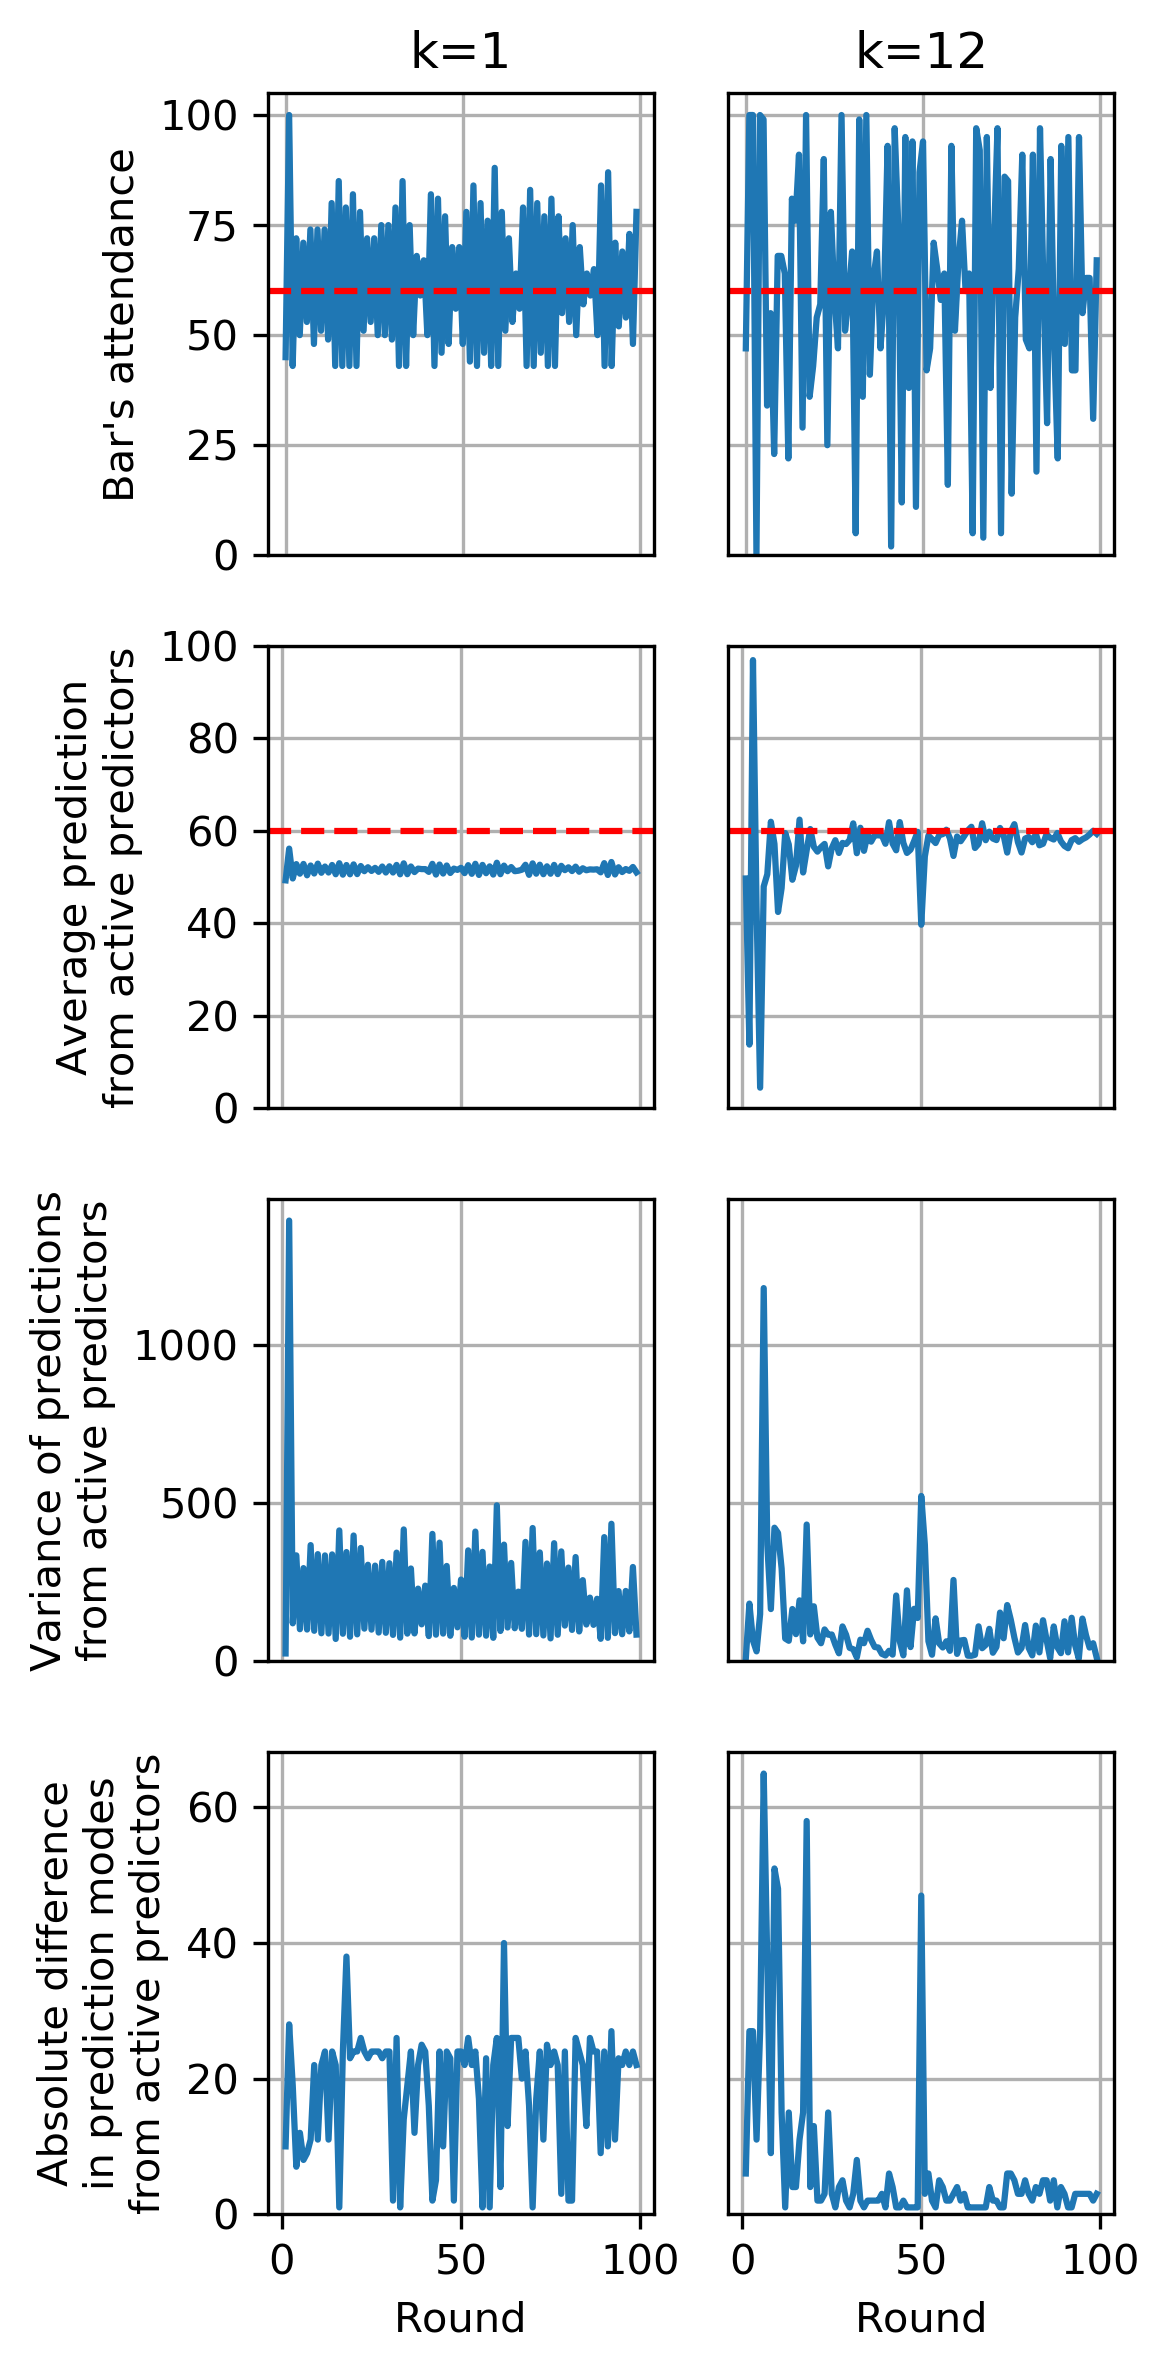

In [10]:
comparar(df1, df12, trial)